# Auto-Encoders for Movie Recommendation System
During this project, we will use the [dataset](https://grouplens.org/datasets/movielens/latest/) of 600 users and 9000 movies with 100000 ratings from Grouplens for a movie recommendation system. The designed stacked Auto-Encoder will determine the ratings of user. 

## Preparing the data

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor') # To use GPU on pytorch
    device = 'cuda'
else:
    device = 'cpu'
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [2]:
# Download the files
!wget -q "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
!unzip ml-latest-small.zip
!del ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [3]:
ratings = pd.read_csv('ml-latest-small/ratings.csv').drop(columns = ['timestamp'])
ratings.head(10)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
5,1,70,3.0
6,1,101,5.0
7,1,110,4.0
8,1,151,5.0
9,1,157,5.0


### Reduce memory usage of the data
Below given approach will reduce ratings' data memory usage from 2.3 MB to 886.4 KB

In [4]:
ratings.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [5]:
ratings.describe().iloc[[3, 7], :]

,userId,movieId,rating
min,1.0,1.0,0.5
max,610.0,193609.0,5.0


In [6]:
ratings[['userId', 'movieId']] = ratings[['userId', 'movieId']].astype('int32')
ratings[['rating']] = ratings[['rating']].astype('int8')
ratings.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   userId   100836 non-null  int32
 1   movieId  100836 non-null  int32
 2   rating   100836 non-null  int8 
dtypes: int32(2), int8(1)
memory usage: 886.4 KB


In [7]:
# Split the ratings data into training and test datasets
df = ratings.copy(deep = True)
training_set = df.iloc[:int(ratings.shape[0]*0.8), :]
test_set = df.iloc[int(ratings.shape[0]*0.8):, :]
print('Shape of Training set: {} and of Test set: {}'.format(training_set.shape, test_set.shape))

Shape of Training set: (80668, 3) and of Test set: (20168, 3)


In [8]:
# Getting the number of users and movies
nb_users = max(df['userId'])
nb_movies = max(df['movieId'])
print('Max value for user id: {} and for movie id: {}'.format(nb_users, nb_movies))

Max value for user id: 610 and for movie id: 193609


In [9]:
# Converting the data into a tensor with userId in rows and movieId in columns
def transform(data: pd.DataFrame) -> torch.tensor:
    new_data = torch.zeros([nb_users, nb_movies], device = device, dtype = torch.float32)
    for user_id in range(1, nb_users + 1):
        id_movies = data.iloc[:, 1][data.iloc[:, 0] == user_id]
        id_ratings = data.iloc[:, 2][data.iloc[:, 0] == user_id]
        user_ratings = np.zeros(nb_movies)
        user_ratings[id_movies - 1] = id_ratings
        new_data[user_id - 1] = new_data[user_id - 1].add(torch.from_numpy(user_ratings).to(device))
    return new_data

training_set = transform(training_set)
test_set = transform(test_set) 

## Building the Auto-Encoder

In [10]:
# Stacked Auto-Encoder architecture
class SAE(nn.Module):
    def __init__(self):
        super(SAE, self).__init__()
        self.fc1 = nn.Linear(nb_movies, 20) # 1st Full connection layer [Encoding]
        self.fc2 = nn.Linear(20, 10) # 2nd Full connection layer [Encoding]
        self.fc3 = nn.Linear(10, 20) # 3rd Full connection layer [Decoding]
        self.fc4 = nn.Linear(20, nb_movies) # 4rd Full connection layer [Output]
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x) 
        return x

model = SAE()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr = 0.01, weight_decay = 0.5)

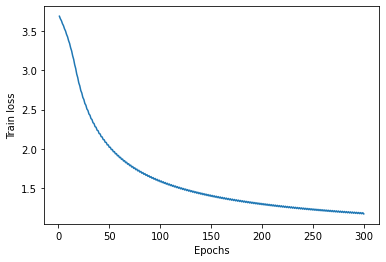

In [11]:
# Training the SAE
nb_epoch, history = 300, {}
for epoch in range(1, nb_epoch + 1):
    train_loss, counter = 0, 0.0 # Keep the count of users rated the movies
    for id_user in range(nb_users):
        input = Variable(training_set[id_user]).unsqueeze(0) # a Batch instead of an 1D array
        target = input.clone() # Input and Target are same
        if torch.sum(target.data > 0) > 0: # Consider users at least once rated
            output = model(input)
            target.require_grad = False
            output[target == 0] = 0 # Exclude non-rated movies from the output
            loss = criterion(output, target)
            mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
            loss.backward()
            train_loss = train_loss + np.sqrt(loss.item() * mean_corrector)
            counter = counter + 1.0
            optimizer.step()
    
    history[epoch] = train_loss/counter

plt.figure()
plt.plot(history.keys(), history.values())
plt.xlabel('Epochs')
plt.ylabel('Train loss')
plt.show()

In [12]:
# Testing the SAE
test_loss, counter = 0, 0.0
for id_user in range(nb_users):
    input = Variable(training_set[id_user]).unsqueeze(0)
    target = Variable(test_set[id_user]).unsqueeze(0)
    if torch.sum(target.data > 0) > 0:
        output = model(input)
        target.require_grad = False
        output[target == 0] = 0
        loss = criterion(output, target)
        mean_corrector = nb_movies/float(torch.sum(target.data > 0) + 1e-10)
        test_loss = test_loss + np.sqrt(loss.item() * mean_corrector)
        counter = counter + 1.0
print("Test loss: {:.3f}".format(test_loss/counter))    

Test loss: 1.376


## Conclusion
We have a test loss of ~1.4 units. In a rating range of $[1, 5]$, this loss indicates that our Stacked Auto-Encoder model will predict the ratings of users with a $\pm$ 1.4 accuracy.